In [1]:
%pylab inline
from sklearn import linear_model
import cv2
from math import exp
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


<h2>Initial Parameters</h2>


Import simulated images

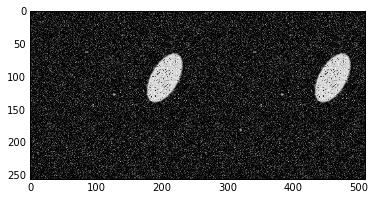

In [2]:
R = cv2.imread('./Images/ReferenceImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 
N = cv2.imread('./Images/NewImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 
row_r, col_r = R.shape
row_n, col_n = N.shape
vis = np.concatenate((R, N), axis=1)
plt.imshow(vis, cmap="Greys_r")

Known image parameters (from simulation)

In [3]:
# Auxiliary functions to calculate PSFs
def gaussian(x, mu, sigma):
    return exp( -(((x-mu)/(sigma))**2)/2.0 )

def get_convolution_matrix(kernel_radius, sigma):
    # compute the kernel elements
    hkernel = [gaussian(x, kernel_radius, sigma) for x in range(2*kernel_radius+1)]
    #nzero = 255 - 2*kernel_radius-1
    #hzero = [0 for x in range(nzero)]
    #hkernel.extend(hzero)
    vkernel = [x for x in hkernel]
    kernel2d = [[xh*xv for xh in hkernel] for xv in vkernel]
   
    # normalize the kernel elements
    kernelsum = sum([sum(row) for row in kernel2d])
    kernel2d = [[x/kernelsum for x in row] for row in kernel2d]
    
    return array(kernel2d)

In [4]:
# Authors specify in code that "noise must be a scalar for the entire image"
sigma_r = 100 #Std. deviation for noise in reference image
sigma_n = 100 #Std. deviation for noise in new image

# PSFs are being represented as tiles of convolution matrixes
tile_size = 25
sigma_PSF = 3.
PSF_r = get_convolution_matrix((tile_size - 1)/2, sigma_PSF) 
PSF_n = get_convolution_matrix((tile_size - 1)/2, sigma_PSF) 

# constant = 0.11957153
# PSF_r = constant*ones((row_r, col_r))
# PSF_n = constant*ones((row_r, col_r))

In [5]:
# extend the kernel to the size of the image
size_e = 255-tile_size
PSF_r_e = np.pad(PSF_r, ((0,size_e),(0,size_e)), mode='constant')
PSF_n_e = np.pad(PSF_n, ((0,size_e),(0,size_e)), mode='constant')


Fourier transforms

In [6]:
fourier_R = fft.fft2(R)
fourier_N = fft.fft2(N)
fourier_PSF_r = fft.fft2(PSF_r_e)
fourier_PSF_n = fft.fft2(PSF_n_e)

<h2>Finding Beta</h2>

Parameters to calculate $\beta$, the ratio of Flux Based Zero Point of the Images

In [7]:
max_iter_beta = 10000 # maximum number of iterations for the fit
beta_epsilon = 0.001 # minimum distance for convergence of the fit
epsilon = 0.001 # avoids division by zero

Fit

In [8]:
# The fit is being donde through sklearn's linear regression
# It appears this is not a robust fit, which the article calls for
def linear_fit(D_r, D_n):
    D_r_elements = D_r.flatten().reshape(-1, 1) 
    D_n_elements = D_n.flatten().reshape(-1, 1) 
    lr_model = linear_model.LinearRegression().fit(D_r_elements, D_n_elements)
    slope = lr_model.coef_[0]
    intercept = lr_model.intercept_
    return slope, intercept

In [9]:
beta = 1
gamma_prime = 0

beta_converges = False
num_iter = 0

while not beta_converges and num_iter < max_iter_beta:
    num_iter = num_iter + 1
    denom = (beta**2)*(sigma_r**2)*(fourier_PSF_n*conjugate(fourier_PSF_n)) + (sigma_n**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
    fourier_D_n = (fourier_PSF_r*fourier_N)/sqrt(denom)
    fourier_D_r = (fourier_PSF_n*fourier_R)/sqrt(denom)
    
    D_n = ifft2(fourier_D_n)
    D_r = ifft2(fourier_D_r)
    
    # Here, they select pixels which are one (really three) sigma above the image noise
    # We don't do that
    
    prev_beta = beta
    # The fit we are using ignores imaginary parts, so we fit the squares instead 
    beta, gamma_prime = linear_fit(real(D_r*conjugate(D_r)), real(D_n*conjugate(D_n)))
    if abs(beta - prev_beta) < beta_epsilon:
        beta_converges = True
gamma = gamma_prime*sqrt(sigma_n**2 + (beta**2)*(sigma_r**2))

# The article claims the number of iterations is usually small (between two and three).
# This is true for this implementation
print('Number of iterations: ' + str(num_iter))
print('Beta: ' + str(beta))
print('Gamma: ' + str(gamma))

Number of iterations: 2
Beta: [ 1.00199215]
Gamma: [ 0.01734449]


<h2>Finding S</h2>

Assignment of Flux Based Zero Points

In [10]:
# Fs are assigned as the article suggests
F_r = 1
F_n = beta

Closed formula

In [11]:
denom =(sigma_r**2)*(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))    
denom = denom + (sigma_n**2)*(F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
fourier_S = (F_n)*(F_r**2)*conjugate(fourier_PSF_n)*(fourier_PSF_r*conjugate(fourier_PSF_r))*fourier_N
fourier_S = fourier_S - (F_r)*(F_n**2)*conjugate(fourier_PSF_r)*(fourier_PSF_n*conjugate(fourier_PSF_n))*fourier_R
fourier_S = fourier_S/denom
S = ifft2(fourier_S)


True

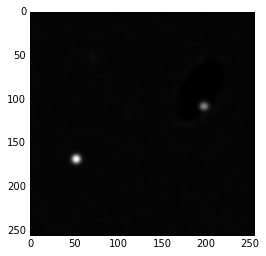

In [12]:

real_S = real(S)
real_fs = real(fourier_S)
maximum_S = amax(real_S)

# We also scale its histogram to 0-255
real_S = (255/maximum_S)*real_S
maximum_S = amax(real_S)

plt.imshow(real_S, cmap="Greys_r")
cv2.imwrite('./Images/S.jpg', real_S)


Global Maxima

In [13]:
print("Maximum: " + str(maximum_S))
print("Points:")
for i in range(len(S)):
    for j in range(len(S)):
        if real_S[i][j] > maximum_S*0.99:
            print("(" + str(i) + "," + str(j) + ")")

Maximum: 255.0
Points:
(168,52)
